## Домашнее задание 3

Стребежев Игорь

In [1]:
%%html
<style>video{width:480px;height:480px}</style>

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib as mpl
% matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.set_printoptions(threshold=np.inf)
plt.rc('animation', html='html5')
plt.rcParams["figure.figsize"] = 8, 8

In [2]:
def split(df):
    Y = df.label.values
    X = df[df.columns.drop('label')].as_matrix()
    return X, Y

df = pd.read_csv(f'spambase_old.csv')
_, Y = split(df)

### task 1

Постройте $\texttt{Precision-recall}$ и $\texttt{ROC}$ кривые для правила типа $\texttt{threshold}\ (x_i \ge a)$ по трем последним признакам (`capital_run_length_average`, `capital_run_length_longest`,
`capital_run_length_total`)

$$ TPR = \frac{TP}{TP + FN},\quad FPR = \frac{TN}{TN + FN} $$

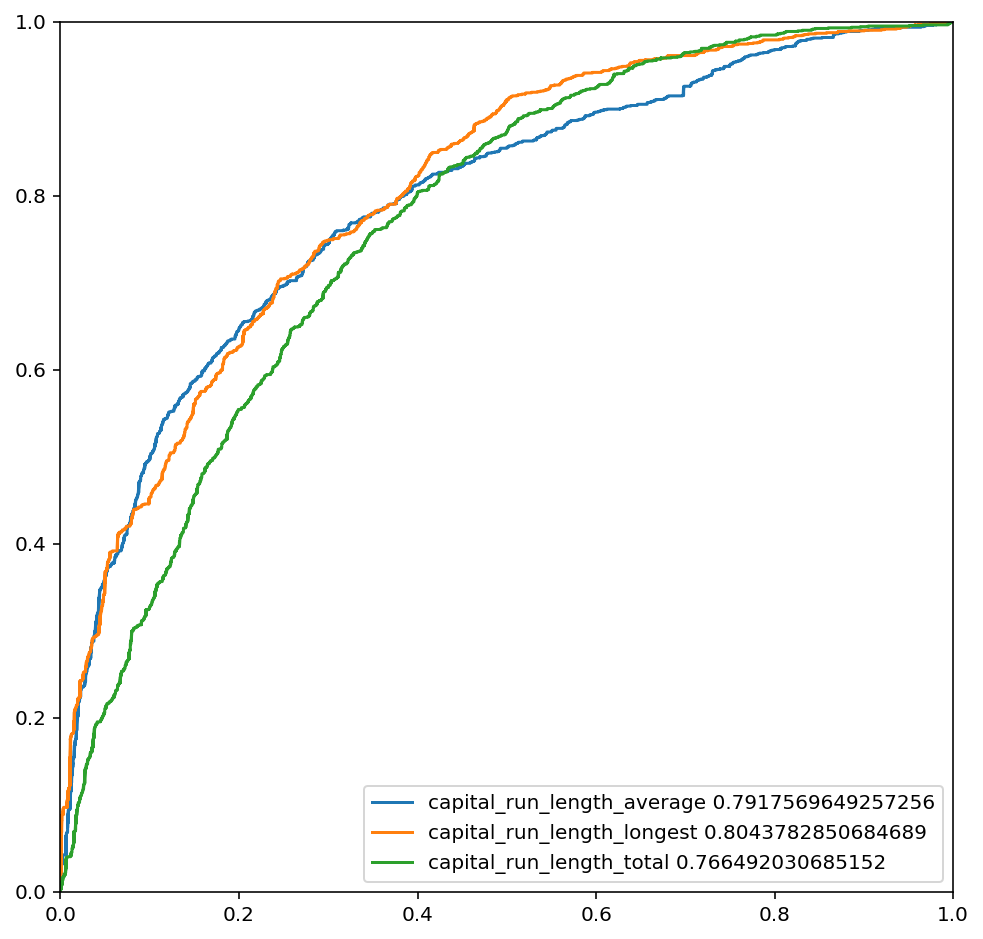

In [8]:
def roc(xs, ys):
    # truthy ys, by descending order of xs
    tys = ys[np.flipud(np.argsort(xs))]
    TPR = np.cumsum(tys) / tys.sum()
    
    # false ys are 1 now
    fys = 1 - tys
    FPR = np.cumsum(fys) / fys.sum()
    
    inds = np.argsort(FPR)
    return FPR[inds], TPR[inds]

def auc(xs, ys):
    rc = roc(xs, ys)
    return np.trapz(rc[1], rc[0])


columns = [ 'capital_run_length_average',
            'capital_run_length_longest',
            'capital_run_length_total', ]

for col in columns:
    rc = roc(df[col].values, Y)
    ac = auc(df[col].values, Y)
    plt.plot(*roc(df[col].values, Y), label=f'{col} {ac}')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()

$$ Recall = \frac{TP}{TP + FN},\quad Precision = \frac{TP}{TP + FP} $$

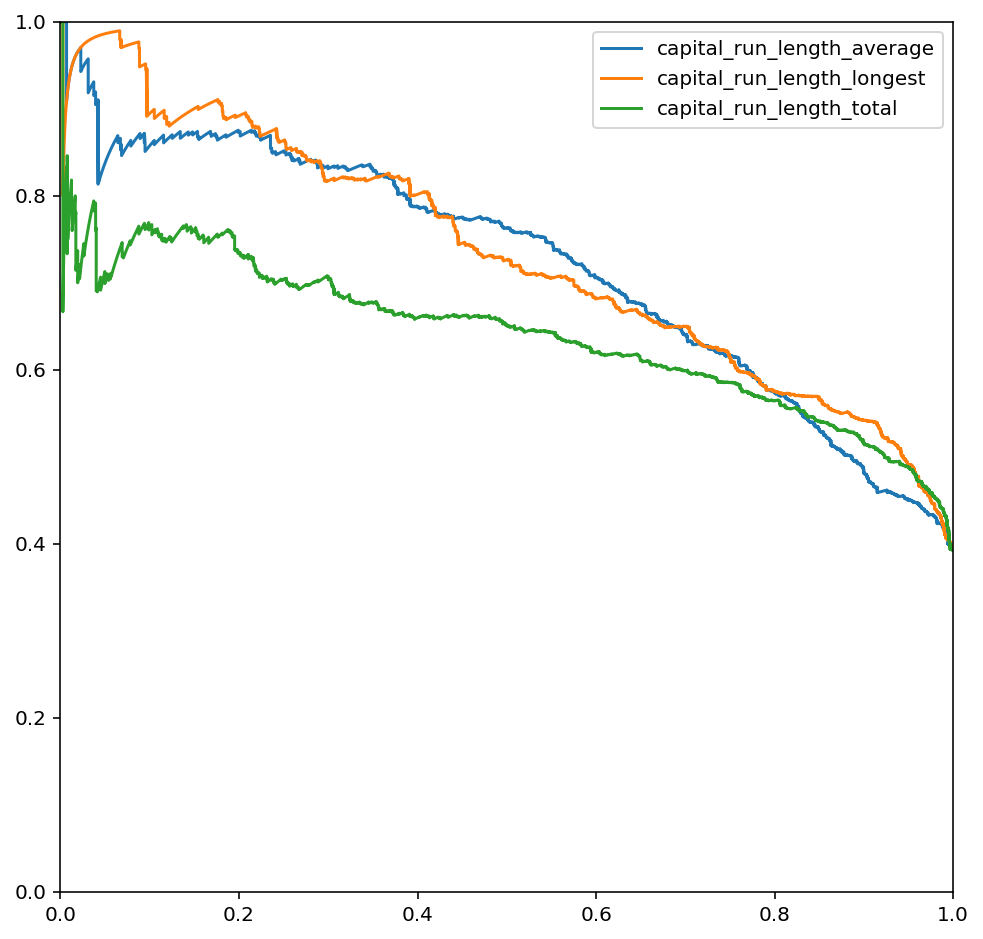

In [17]:
def precision_recall(xs, ys):
    # truthy ys, by descending order of xs
    tys = ys[np.flipud(np.argsort(xs))]
    recall = np.cumsum(tys) / tys.sum()
    
    # false ys are 1 now
    fys = 1 - tys
    precision = np.cumsum(tys) / (np.cumsum(tys) + np.cumsum(fys))
    
    inds = np.argsort(recall)
    return recall[inds], precision[inds]


columns = [ 'capital_run_length_average',
            'capital_run_length_longest',
            'capital_run_length_total', ]

for col in columns:
    plt.plot(*precision_recall(df[col].values, Y), label=col)

plt.xlim([0, 1])
plt.ylim([0, 1])    
plt.legend()

### task 2

Посчитайте $\texttt{AUC}$ для правил типа $\texttt{threshold}$ для всех признаков и найдите 10 лучших.

AUC можно посчитать спомощью [trapezoidal rule](http://en.wikipedia.org/wiki/Trapezoidal_rule).

In [9]:
aucs = [ (col, auc(df[col].values, Y))
            for col in df.columns.drop('label') ]

sorted(aucs, key=lambda p: p[1])[:-11:-1]

[('char_freq_!', 0.8255710116656216),
 ('capital_run_length_longest', 0.8043782850684689),
 ('capital_run_length_average', 0.7917569649257256),
 ('word_freq_your', 0.7796253376992328),
 ('char_freq_$', 0.7770615328642313),
 ('capital_run_length_total', 0.766492030685152),
 ('word_freq_free', 0.7174117337420559),
 ('word_freq_our', 0.7081783206768693),
 ('word_freq_you', 0.707185620398969),
 ('word_freq_remove', 0.6922938776774034)]

### task 3

Реализуйте алгоритмы построения дерева с критерием информационного выигрыша и
критерием Джини и определению класса по мажоритарному классу в листе. Найдите
оптимальную глубину дерева в обоих случаях (в отрезке 2-10).

In [10]:
def H(Y, R, Rsize):
    if Rsize <= 1:
        return 0
    freqs = np.bincount(Y[R]) / Rsize
    return 0 if (freqs == 0).any() else (freqs * np.log2(freqs)).sum()

HH = H

def IG(Y, R):
    Rsize1 = R.sum()
    Rsize0 = Y.size - Rsize1
    return (Rsize1 / Y.size) * H(Y, R,  Rsize1) +\
           (Rsize0 / Y.size) * H(Y, ~R, Rsize0) #-H(X, X.size)


def Gini(Y, R, Rsize):
    if Rsize <= 1:
        return 0
    p = Y[R].sum() / Y.size
    return 1 - p * p


def colThreshold(Y, X):
    igs = [IG(Y, X >= v) for v in X]
    best = np.array(igs).argmax()
    return X[best], igs[best]


def bestThreshold(D, Y):
    inCols = [colThreshold(Y, D[:, c]) for c in np.arange(D.shape[1])]
    vals, igs = zip(*inCols)
    col = np.array(igs).argmax()
    return col, vals[col], igs[col]


def tree(D, Y, h, sp=''):
    if h < 0 or len(Y) == 0: return
    
    stats = np.bincount(Y)
    if (h == 0) or (stats == Y.size).any():
        return stats.argmax()
    
    col, threshold, ig = bestThreshold(D, Y)
    idx = D[:, col] >= threshold
    
    ltree = tree(D[ idx], Y[ idx], h - 1, sp + '  ')
    rtree = tree(D[~idx], Y[~idx], h - 1, sp + '  ')
    return ltree, rtree, col, threshold


def predict(D, tree):
    if isinstance(tree, tuple):
        ltree, rtree, col, threshold = tree
        
        idx = D[:, col] >= threshold
        res = np.zeros(D.shape[0])
        res[ idx] = predict(D[ idx], ltree)
        res[~idx] = predict(D[~idx], rtree)
        
        return res
    else:
        # tree is a class
        return np.full(D.shape[0], tree)

In [11]:
D,  Y  = split(pd.read_csv(f'spambase_old.csv'))
Dn, Yn = split(pd.read_csv(f'spambase_new.csv'))


def test(D, Dn, alg, method):
    global H
    H = alg
    print(f'# {method}')
    for depth in range(2, 11):
        t  = tree(D, Y, depth)
        ac = (predict(Dn, t) == Yn).sum() / Yn.size
        print(f'depth: {depth}, accuracy: {ac}')

In [16]:
test(D, Dn, HH, 'information gain')

# information gain
depth: 2, accuracy: 0.8512486427795874
depth: 3, accuracy: 0.8621064060803475
depth: 4, accuracy: 0.9055374592833876
depth: 5, accuracy: 0.9153094462540716
depth: 6, accuracy: 0.9142236699239956
depth: 7, accuracy: 0.9239956568946797
depth: 8, accuracy: 0.9185667752442996
depth: 9, accuracy: 0.9229098805646037
depth: 10, accuracy: 0.9218241042345277


In [24]:
test(D, Dn, Gini, 'gini')

# gini
depth: 2, accuracy: 0.7882736156351792
depth: 3, accuracy: 0.8219326818675353
depth: 4, accuracy: 0.8642779587404995
depth: 5, accuracy: 0.8686210640608035
depth: 6, accuracy: 0.8773072747014115
depth: 7, accuracy: 0.8827361563517915
depth: 8, accuracy: 0.8849077090119435
depth: 9, accuracy: 0.8751357220412594
depth: 10, accuracy: 0.8621064060803475


### task 4

В задаче 3 используйте только 10 лучших признаков из задачи 2.

In [30]:
best10 = sorted(aucs, key=lambda p: p[1])[:-11:-1]
cols   = [col for col, _ in best10]

D10    = df[cols].as_matrix()
D10n   = (pd.read_csv(f'spambase_new.csv'))[cols].as_matrix()

In [31]:
test(D10, D10n, HH, 'information gain with top 10')

# information gain with top 10
depth: 2, accuracy: 0.8317046688382194
depth: 3, accuracy: 0.8512486427795874
depth: 4, accuracy: 0.8935939196525515
depth: 5, accuracy: 0.8925081433224755
depth: 6, accuracy: 0.8957654723127035
depth: 7, accuracy: 0.8968512486427795
depth: 8, accuracy: 0.8979370249728555
depth: 9, accuracy: 0.8935939196525515
depth: 10, accuracy: 0.8935939196525515


In [27]:
test(D10, D10n, Gini, 'gini with top 10')    

# gini with top 10
depth: 2, accuracy: 0.6796959826275787
depth: 3, accuracy: 0.6862106406080347
depth: 4, accuracy: 0.7633007600434311
depth: 5, accuracy: 0.7643865363735071
depth: 6, accuracy: 0.7665580890336591
depth: 7, accuracy: 0.7719869706840391
depth: 8, accuracy: 0.7785016286644951
depth: 9, accuracy: 0.7752442996742671
depth: 10, accuracy: 0.7817589576547231


### task 5

Реализуйте алгоритм $\texttt{Random Forest}$ для любого типа критерия (информационный выигрыш или Джини) 
с выбором класса по сумме вероятностей. Постройте $\texttt{Precision-recall}$ и $\texttt{ROC}$ кривую
для полученной вероятности на тестовой выборке. 

In [26]:
from numpy.random import choice

H = HH


def getRandomTree(D, depth=8, features=13):
    rows = choice(Y.size, Y.size, replace=True)
    cols = choice(D.shape[1], features)
    Dt   = D[np.ix_(rows, cols)]
    return tree(Dt, Y[rows], depth), cols

def getForest(D, depth, count, features=13):
    return [getRandomTree(D, depth, features) for _ in range(count)]

def predictOnForest(Dn, forest):
    res = np.zeros((Dn.shape[0], len(forest)))
    for i, (tree, cols) in enumerate(forest):
        res[:, i] = predict(Dn[:, cols], tree)
    probabilities = res.sum(axis=1) / len(forest)
    return (probabilities > 0.5) * 1

In [13]:
%%time
f = getForest(D, 8, 25)

CPU times: user 2min 57s, sys: 31.2 ms, total: 2min 57s
Wall time: 2min 57s


cols: 7, depth: 8, count: 25, accuracy: 0.8946796959826275, square: 0.8755822981366459


(0, 1)

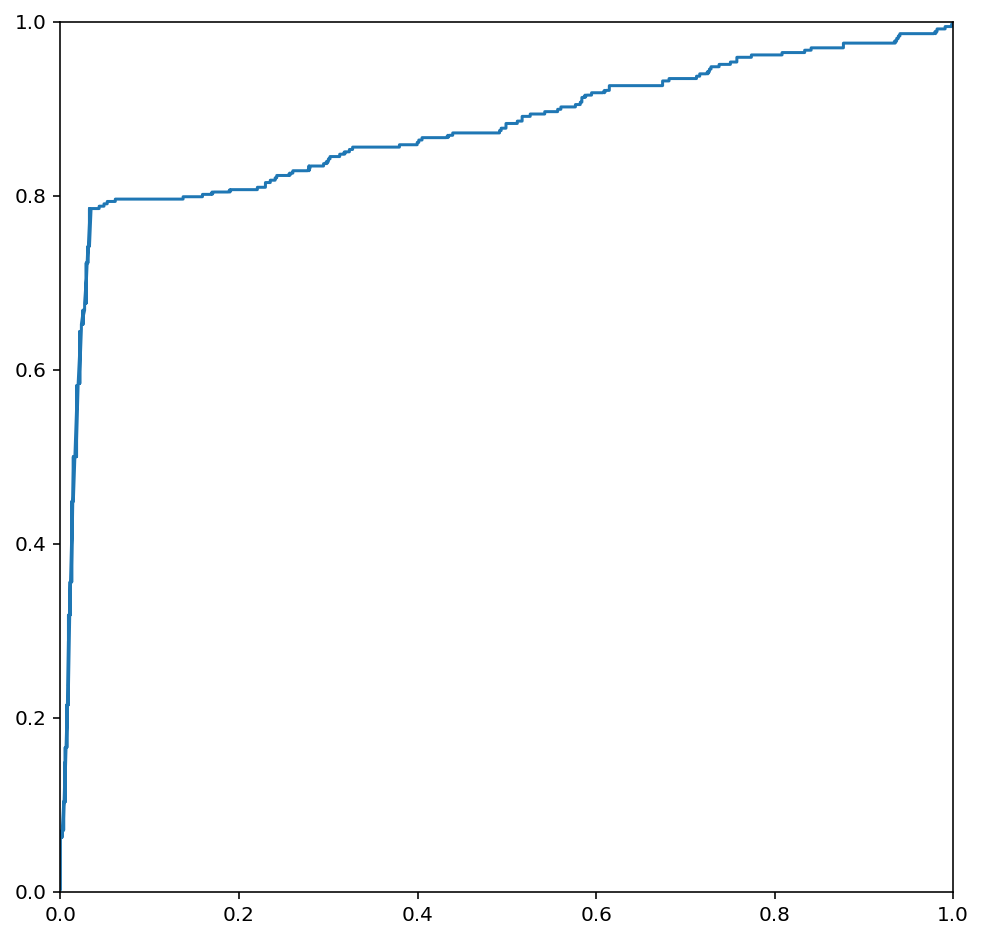

In [15]:
predicted = predictOnForest(Dn, f)
ac = (predicted == Yn).sum() / Yn.size
rc = roc(predicted, Yn)
sq = np.trapz(rc[1], rc[0])

print(f'cols: 7, depth: 8, count: 25, accuracy: {ac}, square: {sq}')
plt.plot(*rc); plt.xlim([0, 1]); plt.ylim([0, 1])

(0, 1)

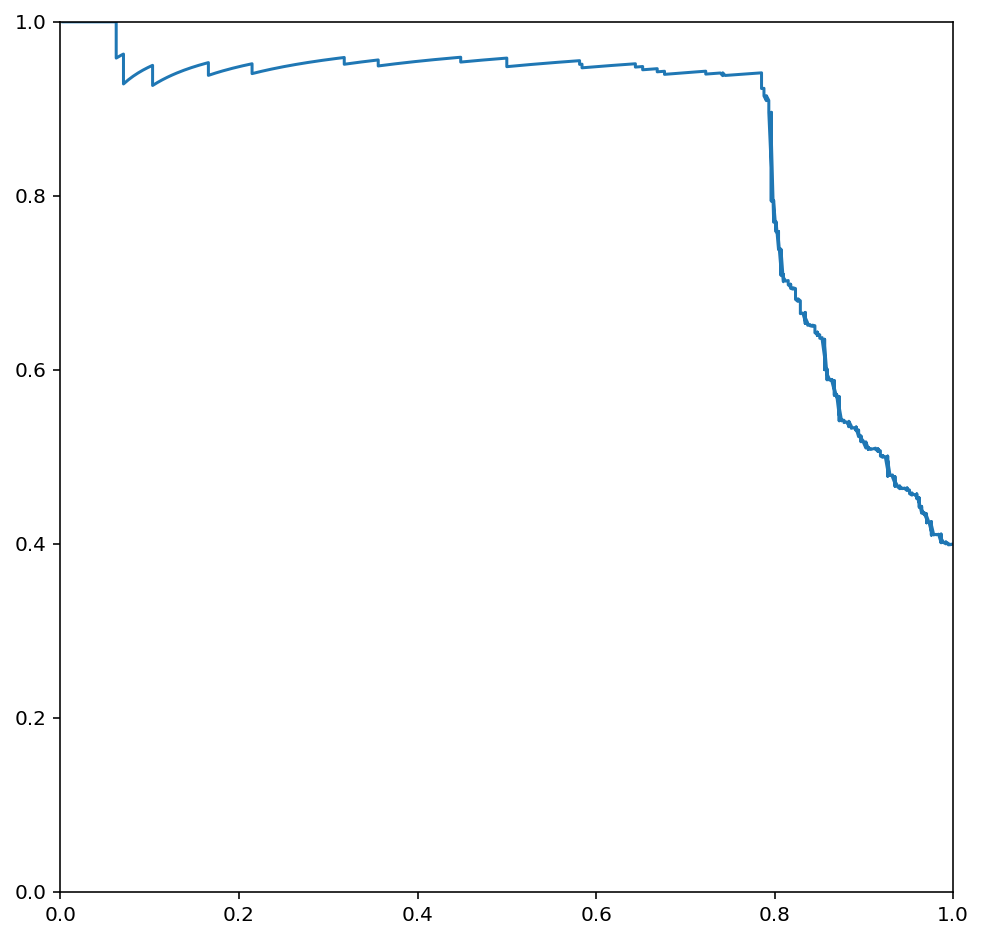

In [18]:
plt.plot(*precision_recall(predicted, Yn)); plt.xlim([0, 1]); plt.ylim([0, 1])

Ради эксперимента построим roc-кривую для обычного дерева, которое строится на всех признаках. Всё супер. Теперь возьмём 35 признаков, 25, 20, 15, 10, 7 признаков и построим ещё одно дерево и roc кривую.

In [20]:
%%time
trees = [(x, getRandomTree(D, 8, x)) for x in [7, 8, 10, 13, 15, 20, 25, 30, 35, 40]]

CPU times: user 2min 56s, sys: 73.4 ms, total: 2min 56s
Wall time: 2min 57s


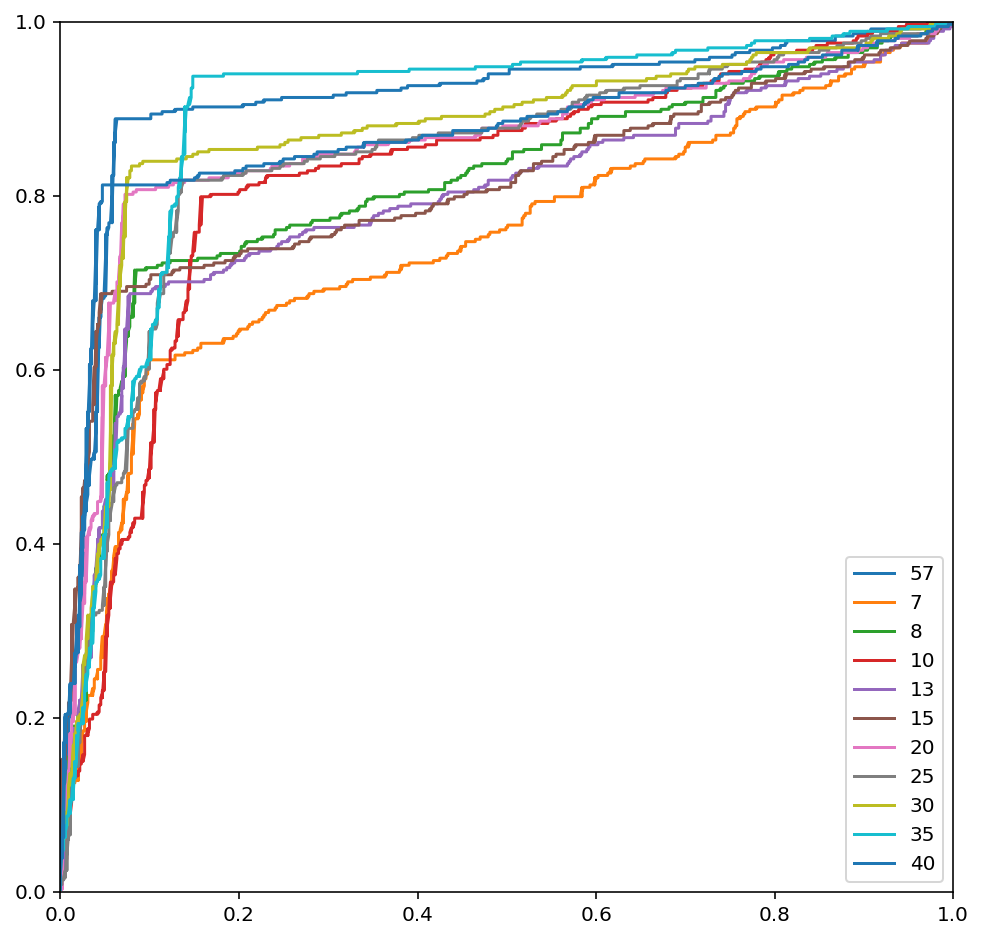

In [21]:
t = tree(D, Y, 8)
plt.plot(*roc(predict(Dn, t), Yn), label='57')

for (x, (t, cols)) in trees:
    plt.plot(*roc(predict(Dn[:, cols], t), Yn), label=str(x))

plt.xlim([0, 1]); plt.ylim([0, 1]); plt.legend();

Попробуем посчитать на деревьях с 13 случайными фичами:

CPU times: user 1min 32s, sys: 17.6 ms, total: 1min 32s
Wall time: 1min 32s


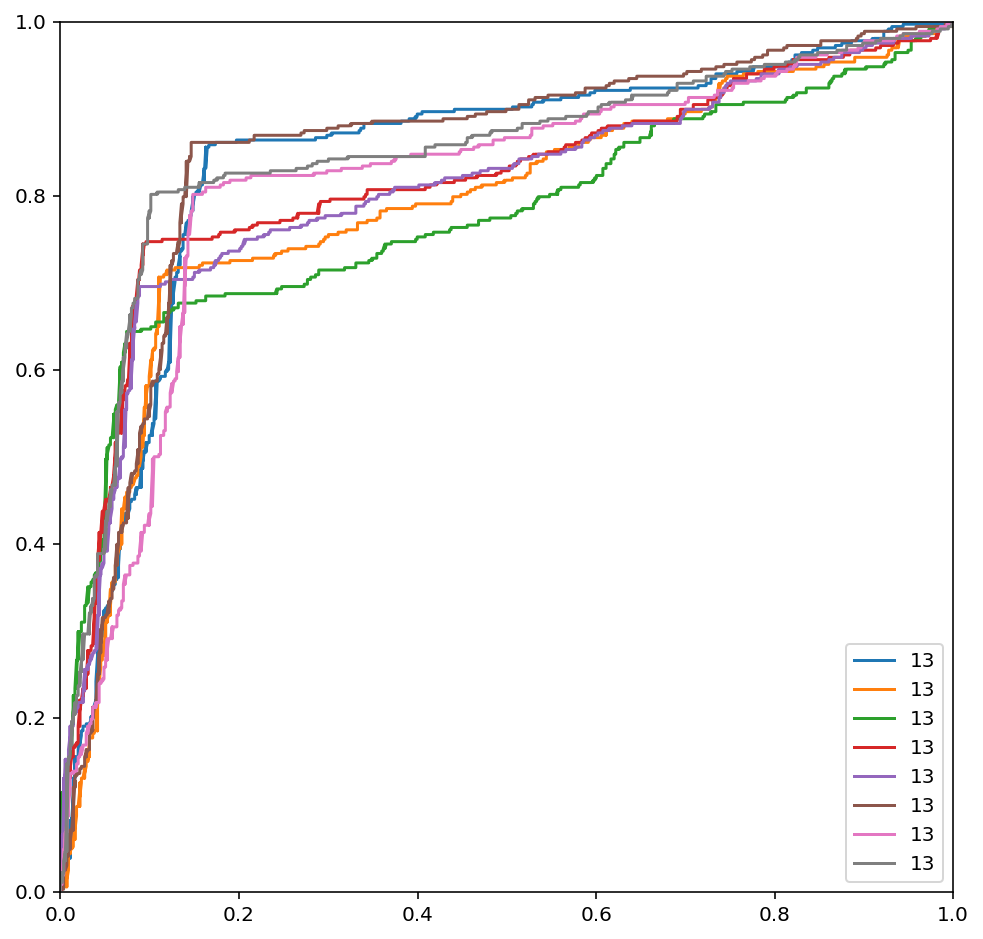

In [22]:
%%time
trees = [(x, getRandomTree(D, 8, x)) for x in [13] * 8]
for (x, (t, cols)) in trees:
    plt.plot(*roc(predict(Dn[:, cols], t), Yn), label=str(x))
plt.xlim([0, 1]); plt.ylim([0, 1]); plt.legend();

### task 6

Оптимизируйте по AUC на тестовой выборке параметры Random Forest: максимальную
глубину деревьев (в отрезке 2-10), количество деревьев (5, 10, 20, 30, 50, 100, 200, 300). В
этой задаче разумно зафиксировать Random Seed. Постройте Precision-recall и ROC кривую
для лучшего варианта.

In [27]:
%%time

maxsq = 0.0
maxparty = []
maxdepth = 0

for depth in range(2, 11):
    print(f'build forest (depth {depth}, size 100)... ', end='')
    f = getForest(D, depth, 100, features=13)
    print('ready')
    
    for i in [5, 10, 20, 30, 50, 100]:
        party = f[:i]
        predicted = predictOnForest(Dn, party)
        rc = roc(predicted, Yn)
        sq = np.trapz(rc[1], rc[0])
        
        if sq > maxsq:
            maxsq    = sq
            maxparty = party
            maxdepth = depth

print(f'the best is of depth {maxdepth}, count {len(maxparty)}, area: {maxsq}')

build forest (depth 2, size 100)... 
ready
build forest (depth 3, size 100)... 
ready
build forest (depth 4, size 100)... 
ready
build forest (depth 5, size 100)... 
ready
build forest (depth 6, size 100)... 
ready
build forest (depth 7, size 100)... 
ready
build forest (depth 8, size 100)... 
ready
build forest (depth 9, size 100)... 
ready
build forest (depth 10, size 100)... 
ready
the best is of depth 8, count 100, area: 0.9121516038996778
CPU times: user 2h 30min 38s, sys: 4.99 s, total: 2h 30min 43s
Wall time: 2h 59min 2s


cols: 13, depth: 8, count: 100, accuracy: 0.9294245385450597, area: 0.9121516038996778


(0, 1)

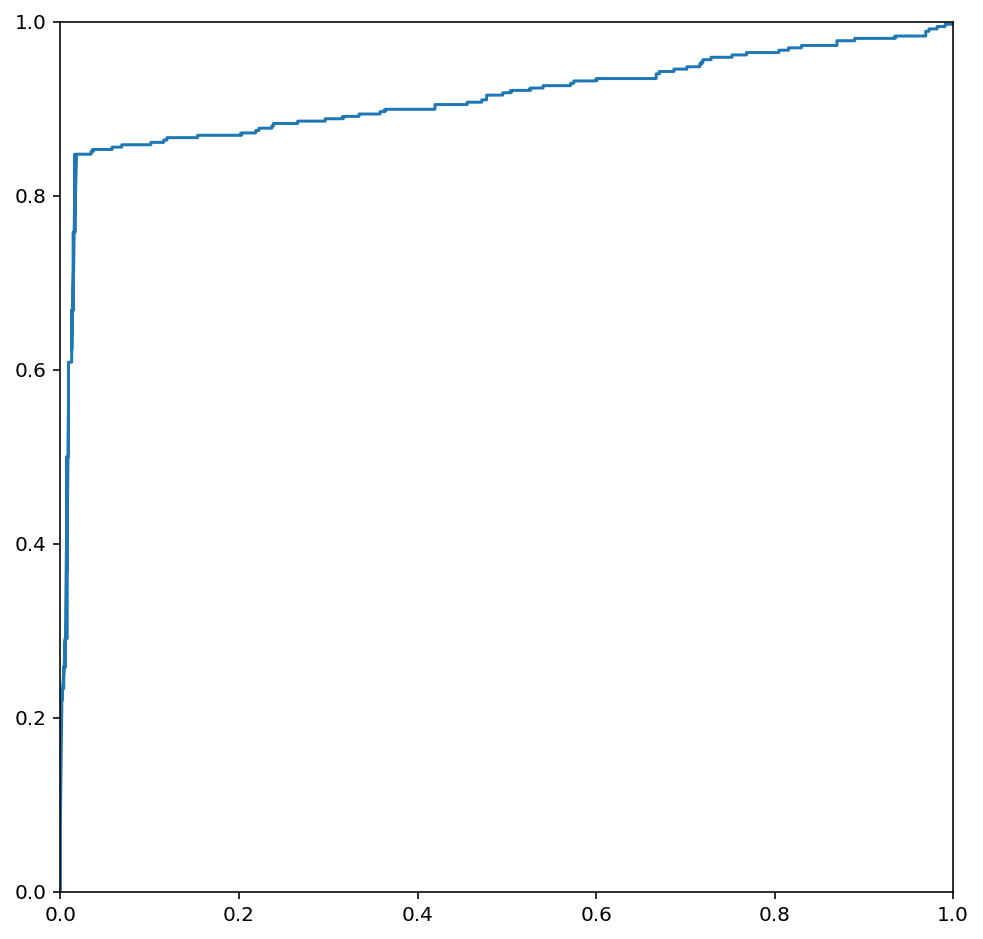

In [28]:
predicted = predictOnForest(Dn, maxparty)
ac = (predicted == Yn).sum() / Yn.size
rc = roc(predicted, Yn)
sq = np.trapz(rc[1], rc[0])

print(f'cols: 13, depth: {maxdepth}, count: {len(party)}, accuracy: {ac}, area: {sq}')
plt.plot(*rc); plt.xlim([0, 1]); plt.ylim([0, 1])

(0, 1)

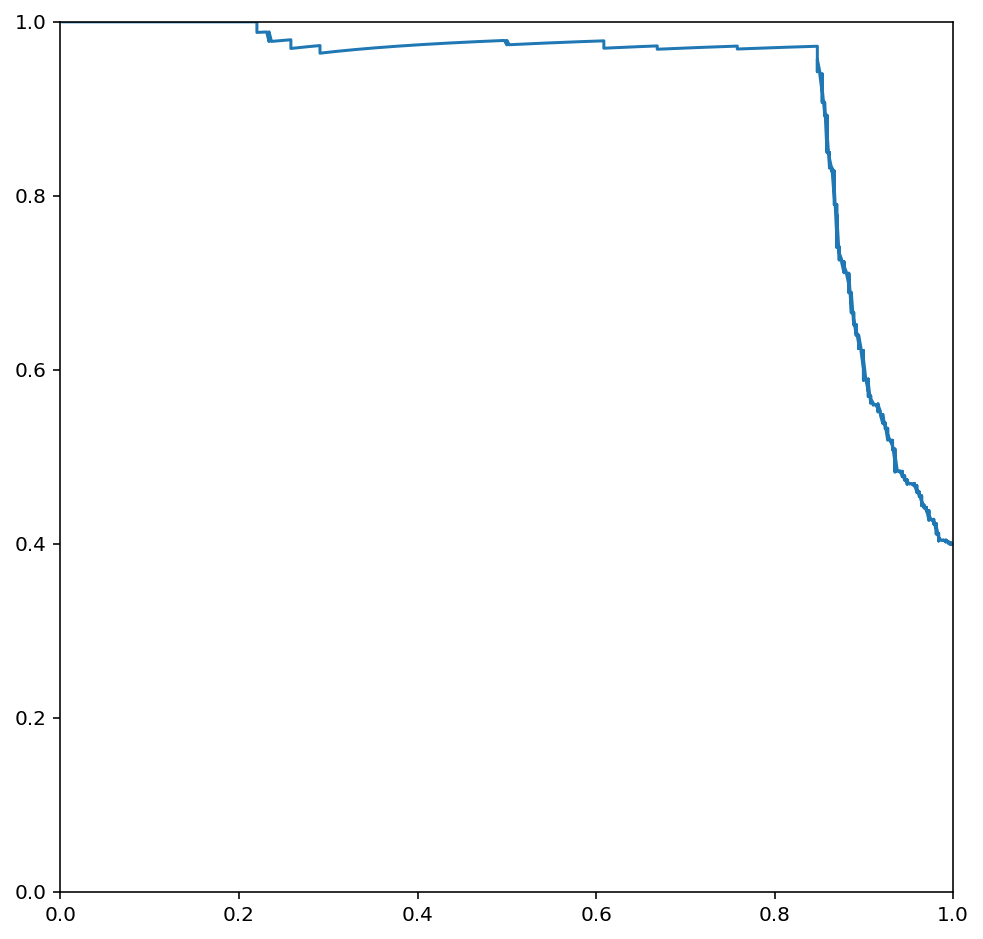

In [29]:
plt.plot(*precision_recall(predicted, Yn)); plt.xlim([0, 1]); plt.ylim([0, 1])